# Generating Simpson's Paradox

We have been maually setting, but now we should also be able to generate it more programatically.  his notebook will describe how we develop some functions that will be included in the `sp_data_util` package.

In [1]:
# %load code/env
# standard imports we use throughout the project
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

import detect_simpsons_paradox as dsp
import sp_data_util as spdata
from sp_data_util import sp_plot

We have been thinking of SP hrough gaussian mixture data, so we'll first work wih that. To cause SP we need he clusters to have an opposite trend of the per cluster covariance. 

In [2]:
# setup
r_clusters = -.6  # correlation coefficient of clusters
cluster_spread = .8 # pearson correlation of means
p_sp_clusters = .5 # portion of clusters with SP 
k = 5 # number of clusters
cluster_size = [2,3]
domain_range = [0, 20, 0, 20]
N = 200 # number of points
p_clusters = [1.0/k]*k

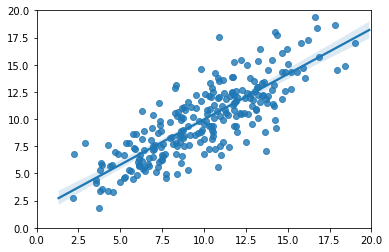

In [3]:
# keep all means in the middle 80%
mu_trim = .2

# sample means
center = [np.mean(domain_range[:2]),np.mean(domain_range[2:])]
mu_transform = np.repeat(np.diff(domain_range)[[0,2]]*(mu_trim),2)
mu_transform[[1,3]] = mu_transform[[1,3]]*-1 # sign flip every other
mu_domain = [d + m_t for d, m_t in zip(domain_range,mu_transform)]
corr = [[1, cluster_spread],[cluster_spread,1]]
d = np.sqrt(np.diag(np.diff(mu_domain)[[0,2]]))
cov = np.dot(d,corr).dot(d)
# sample a lot of means, just for vizualization
# mu = np.asarray([np.random.uniform(*mu_domain[:2],size=k*5), # uniform in x
#          np.random.uniform(*mu_domain[2:],size=k*5)]).T # uniform in y
mu = np.random.multivariate_normal(center, cov,k*50)
sns.regplot(mu[:,0], mu[:,1])
plt.axis(domain_range);
# mu

However independent sampling isn't really very uniform and we'd like to ensure the clusters are more spread out, so we can use some post processing to thin out close ones.  

[0, 20, 0, 20]

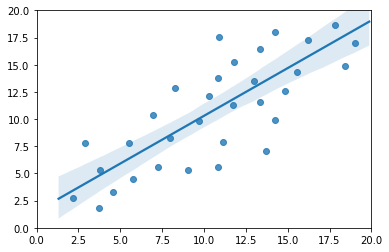

In [4]:
mu_thin = [mu[0]] # keep the first one
p_dist = [1]

# we'll use a gaussian kernel around each to filter and only the closest point matters
dist = lambda mu_c,x: stats.norm.pdf(min(np.sum(np.square(mu_c -x),axis=1)))

for m in mu:
    p_keep = 1- dist(mu_thin,m)
    if p_keep > .99:
        mu_thin.append(m)
        p_dist.append(p_keep)

mu_thin = np.asarray(mu_thin)
sns.regplot(mu_thin[:,0], mu_thin[:,1])
plt.axis(domain_range)

Now, we can sample points on top of that, also we'll only use the first k

[0, 20, 0, 20]

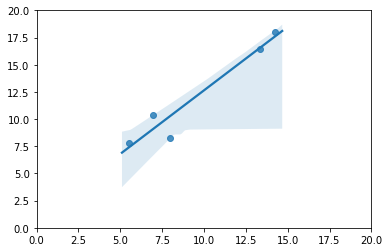

In [5]:
sns.regplot(mu_thin[:k,0], mu_thin[:k,1])
plt.axis(domain_range)

Keeping only a few, we can end up with ones in the center, but if we sort them by the distance to the ones previously selected, we get them spread out a little more

[0, 20, 0, 20]

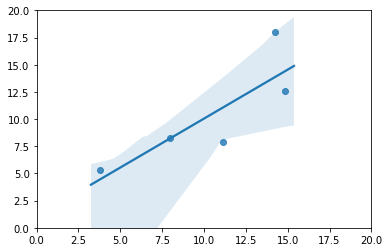

In [6]:

# sort by distance
mu_sort, p_sort = zip(*sorted(zip(mu_thin,p_dist),
            key = lambda x: x[1], reverse =True))

mu_sort = np.asarray(mu_sort)
sns.regplot(mu_sort[:k,0], mu_sort[:k,1])
plt.axis(domain_range)

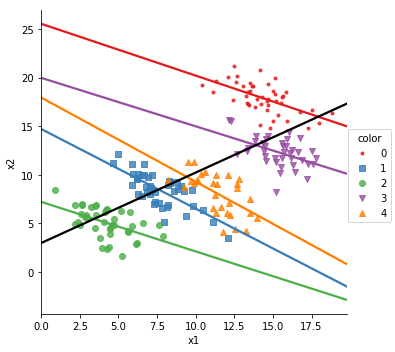

In [7]:
# cluster covariance
cluster_corr = np.asarray([[1,r_clusters],[r_clusters,1]])
cluster_std = np.diag(np.sqrt(cluster_size))
cluster_cov = np.dot(cluster_std,cluster_corr).dot(cluster_std)

# sample from a GMM
z = np.random.choice(k,N,p_clusters)

x = np.asarray([np.random.multivariate_normal(mu_sort[z_i],cluster_cov) for z_i in z])

# make a dataframe
latent_df = pd.DataFrame(data=x,
                       columns = ['x1', 'x2'])

# code cluster as color and add it a column to the dataframe
latent_df['color'] = z

sp_plot(latent_df,'x1','x2','color')

We might not want all of the clusters to have the reveral though, so we can also sample the covariances

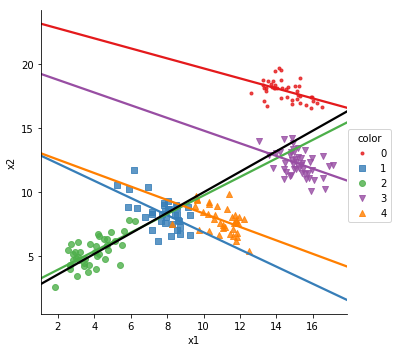

In [8]:
# cluster covariance
cluster_std = np.diag(np.sqrt(cluster_size))
cluster_corr_sp = np.asarray([[1,r_clusters],[r_clusters,1]]) # correlation with sp
cluster_cov_sp = np.dot(cluster_std,cluster_corr_sp).dot(cluster_std) #cov with sp
cluster_corr = np.asarray([[1,-r_clusters],[-r_clusters,1]]) #correlation without sp
cluster_cov = np.dot(cluster_std,cluster_corr).dot(cluster_std) #cov wihtout sp

cluster_covs = [cluster_corr_sp, cluster_corr]
# sample the[0,1] k times
c_sp = np.random.choice(2,k,p=[p_sp_clusters,1-p_sp_clusters])


# sample from a GMM
z = np.random.choice(k,N,p_clusters)

x = np.asarray([np.random.multivariate_normal(mu_sort[z_i],cluster_covs[c_sp[z_i]]) for z_i in z])

# make a dataframe
latent_df = pd.DataFrame(data=x,
                       columns = ['x1', 'x2'])

# code cluster as color and add it a column to the dataframe
latent_df['color'] = z

sp_plot(latent_df,'x1','x2','color')

In [9]:
[p_sp_clusters,1-p_sp_clusters]

[0.5, 0.5]

In [10]:
c_sp

array([0, 0, 1, 0, 0])

We'll call this construction of SP `geometric_2d_gmm_sp` and it's included in the `sp_data_utils` module now, so it can be called as follows. We'll change the portion of clusters with SP to 1, to ensure that all are SP. 

In [11]:
type(r_clusters)
type(cluster_size)
type(cluster_spread)
type(p_sp_clusters)
type(domain_range)
type(p_clusters)

list

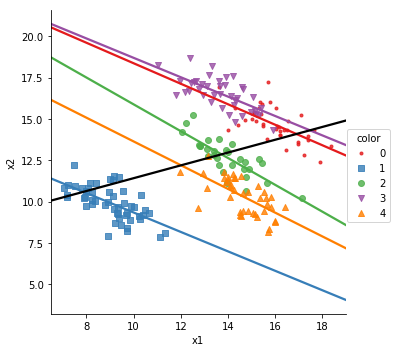

In [12]:
p_sp_clusters = .9
sp_df2 = spdata.geometric_2d_gmm_sp(r_clusters,cluster_size,cluster_spread,
                                    p_sp_clusters, domain_range,k,N,p_clusters)
sp_plot(sp_df2,'x1','x2','color')

With this, we can start to see how the parameters control a little

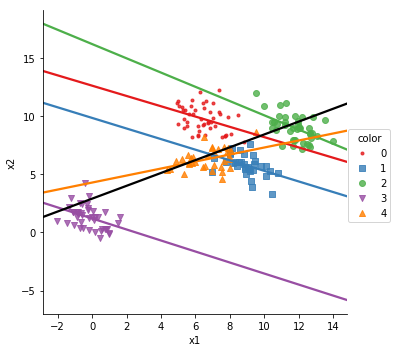

In [13]:
# setup
r_clusters = -.4  # correlation coefficient of clusters
cluster_spread = .8 # pearson correlation of means
p_sp_clusters = .6 # portion of clusters with SP 
k = 5 # number of clusters
cluster_size = [4,4]
domain_range = [0, 20, 0, 20]
N = 200 # number of points
p_clusters = [.5, .2, .1, .1, .1]

sp_df3 = spdata.geometric_2d_gmm_sp(r_clusters,cluster_size,cluster_spread,
                                    p_sp_clusters, domain_range,k,N,p_clusters)
sp_plot(sp_df3,'x1','x2','color')

We might want to add multiple views, so we added a function that takes the same parameters or lists to allow each view to have different parameters. We'll look first at just two views with the same parameters, both as one another and as above

(200, 4)


,x1,x2,x3,x4,A,B
0,10.957861,10.322141,12.836613,10.914427,A4,B1
1,17.414306,19.867756,7.198428,10.280704,A3,B4
2,18.520472,17.772962,13.190766,11.650172,A3,B1
3,12.313612,10.128932,9.091296,9.438021,A4,B0
4,16.713511,11.946388,6.868967,7.472568,A1,B3


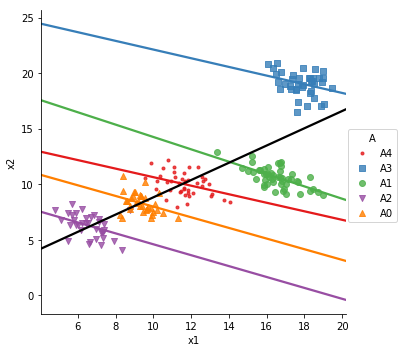

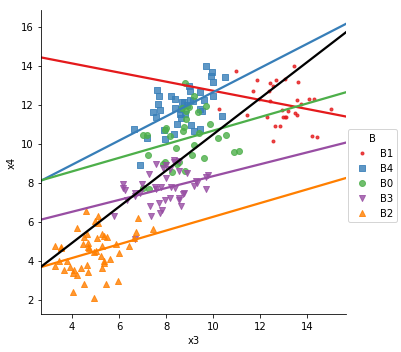

In [23]:

many_sp_df = spdata.geometric_indep_views_gmm_sp(2,r_clusters,cluster_size,cluster_spread,p_sp_clusters,
                domain_range,k,N,p_clusters)

sp_plot(many_sp_df,'x1','x2','A')
sp_plot(many_sp_df,'x3','x4','B')
many_sp_df.head()

We can also look at the pairs of variables that we did not design SP into and see that they have vey different structure

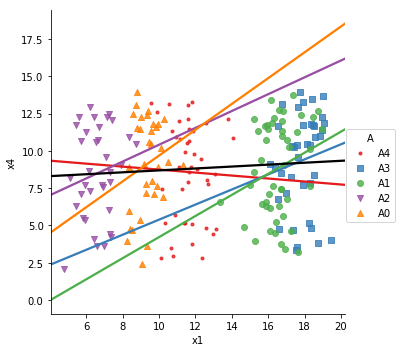

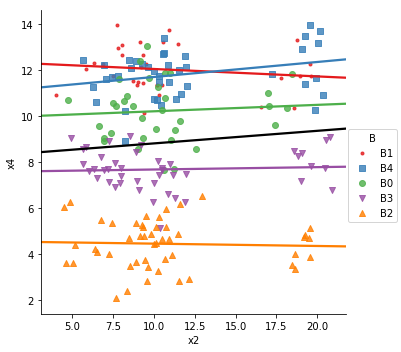

In [24]:
sp_plot(many_sp_df,'x1','x4','A')
sp_plot(many_sp_df,'x2','x4','B')

And we can set up the views to be different from one another by design

(200, 4)


,x1,x2,x3,x4,A,B
0,8.478525,12.007040,10.814343,16.927109,A2,B1
1,13.248617,13.309187,13.286343,9.462923,A0,B2
2,14.237572,15.470561,7.709910,11.254668,A0,B0
3,8.306488,9.462728,14.246332,9.562048,A2,B2
4,13.963761,13.676798,6.261499,10.108301,A0,B0


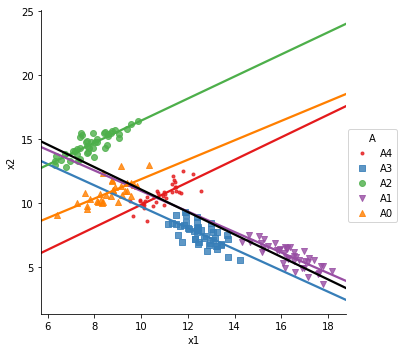

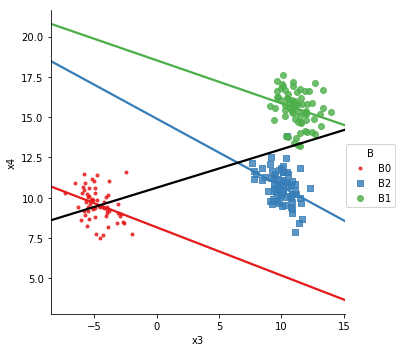

In [34]:
# setup
r_clusters = [.8, -.2]  # correlation coefficient of clusters
cluster_spread = [.8, .2] # pearson correlation of means
p_sp_clusters = [.6, 1] # portion of clusters with SP 
k = [5,3] # number of clusters
cluster_size = [4,4]
domain_range = [0, 20, 0, 20]
N = 200 # number of points
p_clusters = [[.5, .2, .1, .1, .1],[1.0/3]*3]


many_sp_df_diff = spdata.geometric_indep_views_gmm_sp(2,r_clusters,cluster_size,cluster_spread,p_sp_clusters,
                domain_range,k,N,p_clusters)

sp_plot(many_sp_df_diff,'x1','x2','A')
sp_plot(many_sp_df_diff,'x3','x4','B')
many_sp_df.head()

And we can run our detection algorithm on this as well.

In [35]:
dsp.detect_simpsons_paradox(many_sp_df_diff)

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup
0,-0.864505,0,1,0.697127,A,A0
1,0.022007,0,2,-0.029711,A,A1
2,-0.864505,0,1,0.824355,A,A2
3,0.022007,0,2,-0.072966,A,A2
4,0.031989,1,2,-0.137786,A,A2
5,0.049479,1,3,-0.051841,A,A2
6,-0.019909,0,3,0.101901,A,A3
7,0.049479,1,3,-0.036639,A,A3
8,-0.864505,0,1,0.754853,A,A4
9,-0.019909,0,3,0.081068,A,A4


We designed in SP to occur between attributes 0 & 1 in group by A and 2 & 3 in grouby by B, for portions fo the subgroups.  We detect other occurences. 